<a href="https://colab.research.google.com/github/kmouleejunhyuk/windturbine/blob/main/windturbine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 풍력발전기 상태이상 판별 과제

In [1]:
###
#python, pytorch
#data not encluded due to copyrights issue

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook

import sys
import time
import random

In [3]:
#구글 드라이브 마운트 & 경로설정
from google.colab import drive
drive.mount('/gdrive')

PATH='/gdrive/My Drive/windturbine'

Mounted at /gdrive


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using device: ", device)

using device:  cuda


In [5]:
#seed for reproducability
random_seed=49   #44159
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

#### Data loading and EDA

In [6]:
#data import
train_raw=pd.read_csv(PATH+'/training_data_set.csv')
test_raw=pd.read_csv(PATH+'/validation_data_set.csv')

In [7]:
#EDA helper function
def EDA(df: pd.DataFrame):
    print(df.head(), '\n')
    print(df.dtypes, '\n')

    for _ in df.columns:
        if df[_].isna().sum() != 0 or df[_].dtypes != 'float64':
            #static information
            print('column '+ _ + ' static info')
            print('max:', '\t\t', df[_].max())
            print('min:', '\t\t', df[_].min())
            print('avg:', '\t\t', df[_].mean())
            print('count of na: ', '\t\t', df[_].isna().sum())
            print('unique values: ', '\t\t', df[_].nunique(dropna=False))

            #plot boxplot by column
            source=df[_].copy()
            plt.rcParams['figure.figsize']=[10, 6]
            plt.title(_)
            plt.boxplot(source, notch=1, sym='rs', vert=0)
            plt.show()
            plt.close()
            print('\n')

        #else: print('no na and float value in column {}. max: {}, min: {}, avg: {} \n'.format(_, df[_].max(), df[_].min(), df[_].mean()))

          1         2    3    4         5  ...  682  683  684  685  686
0  0.621211  0.771822  0.5  0.5  0.618948  ...    0    0    0    0    1
1  0.624648  0.319315  0.5  0.5  0.625634  ...    0    0    0    0    1
2  0.625174  0.244754  0.5  0.5  0.626474  ...    0    0    0    0    1
3  0.628112  0.266645  0.5  0.5  0.627791  ...    0    0    0    0    1
4  0.629918  0.204191  0.5  0.5  0.629838  ...    0    0    0    0    1

[5 rows x 686 columns] 

1      float64
2      float64
3      float64
4      float64
5      float64
        ...   
682      int64
683      int64
684      int64
685      int64
686      int64
Length: 686, dtype: object 

column 681 static info
max: 		 1
min: 		 0
avg: 		 0.1825
count of na:  		 0
unique values:  		 2


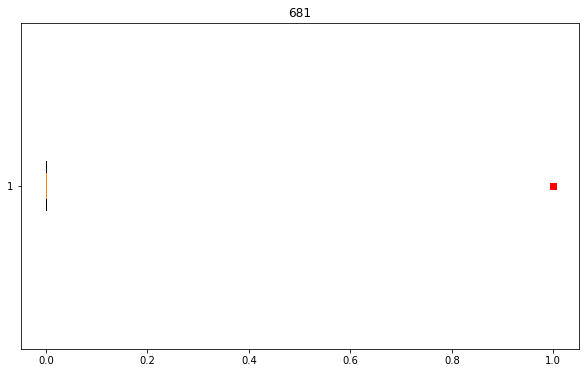



column 682 static info
max: 		 1
min: 		 0
avg: 		 0.1825
count of na:  		 0
unique values:  		 2


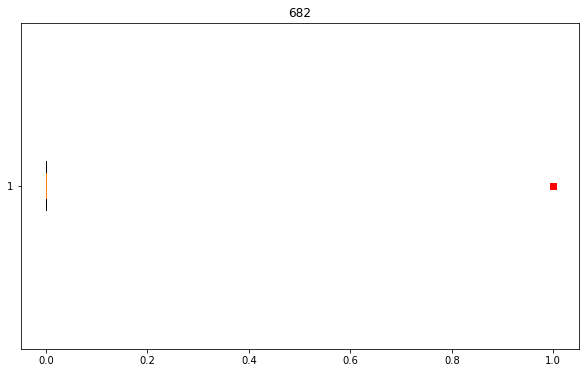



column 683 static info
max: 		 1
min: 		 0
avg: 		 0.14625
count of na:  		 0
unique values:  		 2


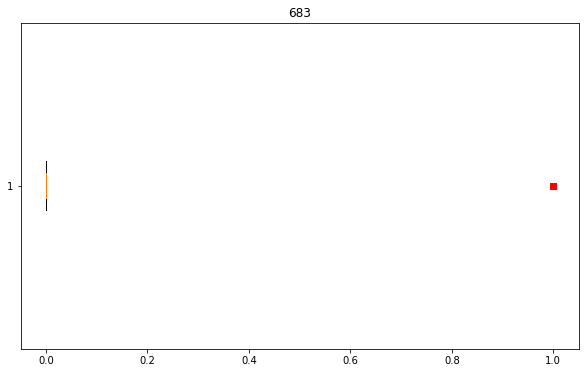



column 684 static info
max: 		 1
min: 		 0
avg: 		 0.1625
count of na:  		 0
unique values:  		 2


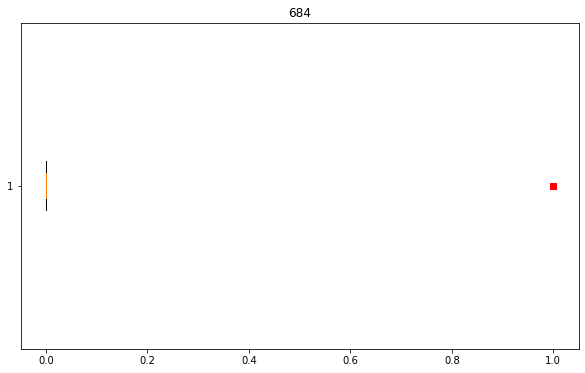



column 685 static info
max: 		 1
min: 		 0
avg: 		 0.16375
count of na:  		 0
unique values:  		 2


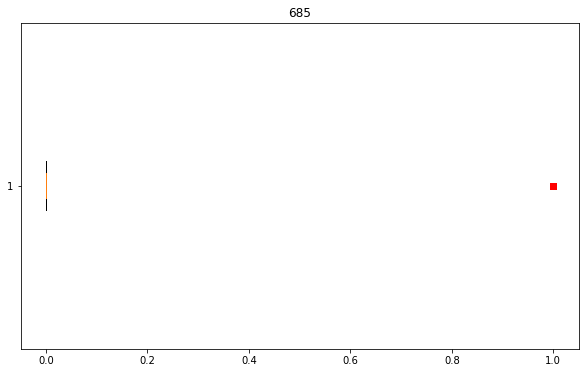



column 686 static info
max: 		 1
min: 		 0
avg: 		 0.1625
count of na:  		 0
unique values:  		 2


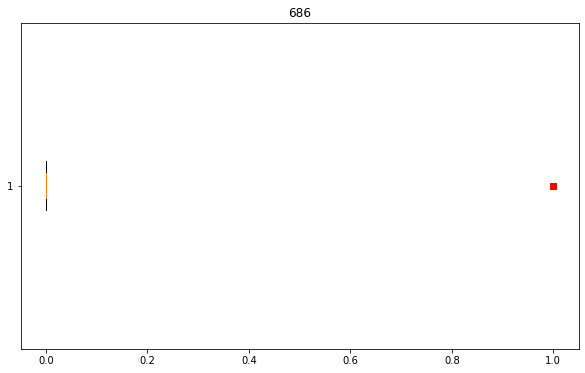

In [8]:
EDA(train_raw)

          1         2    3    4         5  ...  682  683  684  685  686
0  1.019280  1.240127  0.5  0.5  1.018462  ...    0    0    0    0    1
1  1.019262  1.248247  0.5  0.5  1.018890  ...    0    0    0    0    1
2  1.023792  1.286444  0.5  0.5  1.024392  ...    0    0    0    0    1
3  1.023431  1.364974  0.5  0.5  1.023545  ...    0    0    0    0    1
4  1.018795  1.277456  0.5  0.5  1.021053  ...    0    0    0    0    1

[5 rows x 686 columns] 

1      float64
2      float64
3      float64
4      float64
5      float64
        ...   
682      int64
683      int64
684      int64
685      int64
686      int64
Length: 686, dtype: object 

column 681 static info
max: 		 1
min: 		 0
avg: 		 0.19
count of na:  		 0
unique values:  		 2


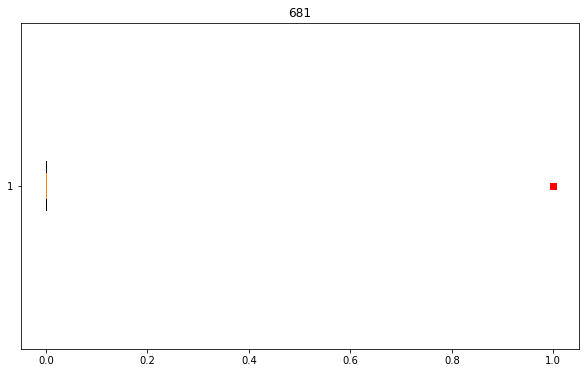



column 682 static info
max: 		 1
min: 		 0
avg: 		 0.13
count of na:  		 0
unique values:  		 2


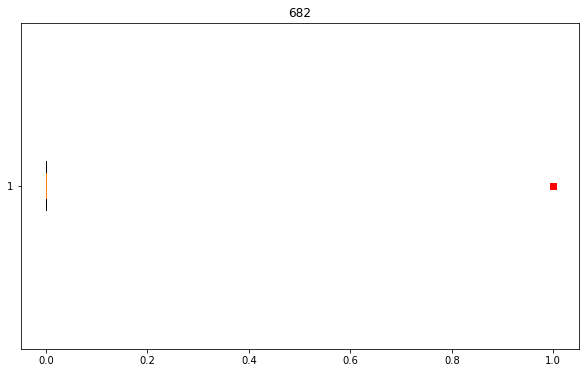



column 683 static info
max: 		 1
min: 		 0
avg: 		 0.19
count of na:  		 0
unique values:  		 2


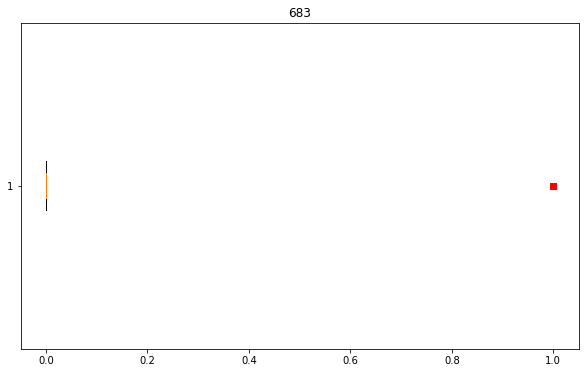



column 684 static info
max: 		 1
min: 		 0
avg: 		 0.13
count of na:  		 0
unique values:  		 2


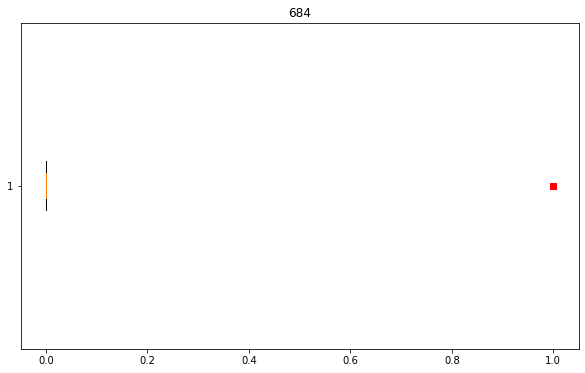



column 685 static info
max: 		 1
min: 		 0
avg: 		 0.22
count of na:  		 0
unique values:  		 2


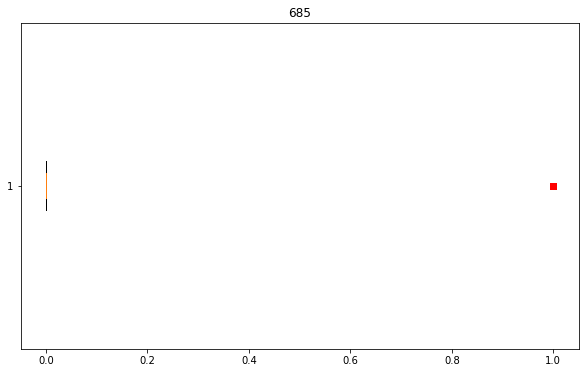



column 686 static info
max: 		 1
min: 		 0
avg: 		 0.14
count of na:  		 0
unique values:  		 2


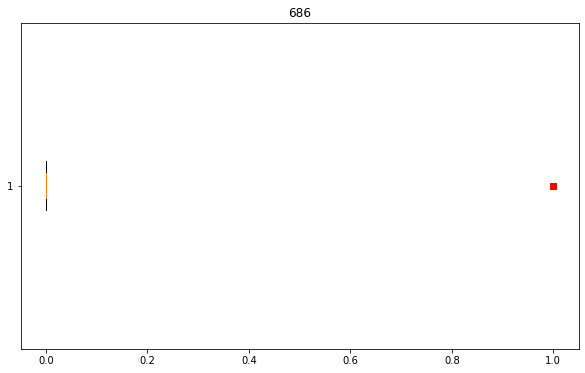

In [9]:
EDA(test_raw)

In [10]:
##column 681~686 seems to be one-hot encoded target value

#### preparing data

In [11]:
train_raw=train_raw.sample(frac=1).reset_index(drop=True)

row=train_raw.shape[0]
train=train_raw.iloc[:int(row*0.9)]
valid=train_raw.iloc[int(row*0.9):]

In [12]:
y_train=train[[str(x) for x in range(681, 687)]]
x_train=train[[str(x) for x in range(1, 681)]]

y_valid=valid[[str(x) for x in range(681, 687)]]
x_valid=valid[[str(x) for x in range(1, 681)]]

y_test=test_raw[[str(x) for x in range(681, 687)]]
x_test=test_raw[[str(x) for x in range(1, 681)]]

In [13]:
y_train.iloc[0]

681    0
682    0
683    0
684    0
685    1
686    0
Name: 0, dtype: int64

In [30]:
#changing one-hot encoded target value to single integer value(0~6)
y_train['target']=np.argmax(y_train.copy().values, axis=1)
y_valid['target']=np.argmax(y_valid.copy().values, axis=1)
y_test['target']=np.argmax(y_test.copy().values, axis=1)

y_train=y_train['target'].copy()
y_valid=y_valid['target'].copy()
y_test=y_test['target'].copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [31]:
np.unique(y_test.values, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([3800, 2600, 3800, 2600, 4400, 2800]))

In [16]:
#from sklearn.preprocessing import RobustScaler
#trans=RobustScaler().fit(x_train.values)
#x_train=pd.DataFrame(data=trans.transform(x_train.values), columns=x_train.columns)
#x_test=pd.DataFrame(data=trans.transform(x_test.values), columns=x_test.columns)

In [32]:
x_train

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680
0,0.810134,0.793202,0.482405,0.382047,0.810444,0.793849,0.479069,0.359679,0.810557,0.796416,0.477426,0.348749,0.810927,0.797314,0.474451,0.329339,0.809663,0.800481,0.474599,0.330770,0.807387,0.804455,0.476452,0.344428,0.805608,0.810540,0.482146,0.381622,0.804771,0.812580,0.484966,0.401176,0.803459,0.816411,0.491081,0.441170,0.804587,0.814646,0.491511,0.444236,...,0.723966,0.738184,0.523398,0.656205,0.723439,0.738941,0.527085,0.682342,0.723652,0.741956,0.533100,0.721484,0.726455,0.740286,0.534281,0.728607,0.728887,0.738686,0.534325,0.729179,0.731024,0.739490,0.535816,0.738908,0.732839,0.741127,0.537347,0.749678,0.734289,0.743839,0.540318,0.769302,0.737461,0.743690,0.540519,0.770159,0.738999,0.745586,0.541997,0.780604
1,0.562420,0.848917,0.564682,0.565043,0.562420,0.851811,0.570701,0.570866,0.562420,0.853812,0.576083,0.576217,0.562420,0.856329,0.576592,0.576710,0.562420,0.858642,0.585460,0.585536,0.562420,0.859774,0.579271,0.578933,0.562420,0.860738,0.578614,0.578749,0.562420,0.861779,0.572702,0.572447,0.562420,0.862291,0.568937,0.568748,0.562420,0.862236,0.547206,0.546406,...,0.562420,0.626642,0.456881,0.456763,0.562420,0.624691,0.459088,0.459321,0.562420,0.622777,0.463055,0.463149,0.562420,0.621569,0.470325,0.470649,0.562420,0.620603,0.477555,0.477725,0.562420,0.618886,0.482042,0.482083,0.562420,0.617944,0.480240,0.480227,0.562420,0.618125,0.488072,0.488554,0.562420,0.618892,0.498482,0.498720,0.562420,0.619178,0.507505,0.507812
2,0.696821,0.698705,0.429113,0.027354,0.694227,0.698463,0.430729,0.039315,0.692153,0.699647,0.434479,0.063765,0.689979,0.699754,0.437696,0.085980,0.687532,0.701434,0.442963,0.120881,0.683392,0.703437,0.449745,0.167431,0.680230,0.706825,0.459356,0.230758,0.679906,0.705083,0.464279,0.263178,0.678794,0.704443,0.470141,0.302385,0.677751,0.703307,0.475743,0.339692,...,0.745422,0.740559,0.479880,0.366183,0.744298,0.740160,0.479745,0.364700,0.742427,0.739888,0.479821,0.365913,0.740804,0.741666,0.482039,0.380628,0.740610,0.740230,0.481692,0.377814,0.740283,0.738557,0.481086,0.373372,0.741117,0.735050,0.477961,0.352207,0.740864,0.733563,0.475556,0.336955,0.738742,0.735985,0.477205,0.348548,0.737935,0.735768,0.477526,0.349946
3,0.791528,0.849988,0.500000,-0.232082,0.792168,0.853103,0.500000,-0.131238,0.791902,0.854860,0.500000,-0.035411,0.789492,0.862958,0.500000,0.124322,0.790004,0.865985,0.500000,0.245144,0.790641,0.868293,0.500000,0.366548,0.791154,0.869363,0.500000,0.482331,0.790476,0.873204,0.500000,0.619419,0.789212,0.878393,0.500000,0.771554,0.788785,0.882785,0.500000,0.928234,...,0.793031,0.797829,0.500000,-1.043412,0.793615,0.798736,0.500000,-1.033562,0.792664,0.800772,0.500000,-1.013350,0.792870,0.803704,0.500000,-0.985397,0.792296,0.806739,0.500000,-0.951767,0.793295,0.808264,0.500000,-0.925278,0.794278,0.808067,0.500000,-0.908877,0.795131,0.808527,0.500000,-0.891173,0.794599,0.811654,0.500000,-0.853341,0.796631,0.810853,0.500000,-0.839064
4,1.117349,1.092108,0.499698,-1.255189,1.124335,1.085189,0.500000,-1.360143,1.123970,1.082393,0.500000,-1.443517,1.111133,1.096572,0.503686,-1.381361,1.114272,1.095565,0.500000,-1.412078,1.113462,1.094810,0.500000,-1.443887,1.091970,1.121786,0.499679,-1.232567,1.097695,1.115343,0.500000,-1.240360,1.096036,1.112909,0.500000,-1.225719,1.095010,1.114309,0.500000,-1.179372,...,1.126014,1.109942,0.500001,2.279686,1.122674,1.118345,0.500000,2.317405,1.124353,1.120923,0.500000,2.320228,1.123541,1.123848,0.500000,2.328065,1.124660,1.127365,0.500000,2.347819,1.125476,1.126730,0.500000,2.338362,1.124883,1.131736,0.500000,2.374637,1.126834,1.131431,0.500000,2.370367,1.126101,1.135781,0.500000,2.404705,1.124537,1.139727,0.500000,2.445945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [33]:
y_train

0        4
1        1
2        4
3        2
4        2
        ..
71995    5
71996    4
71997    0
71998    4
71999    3
Name: target, Length: 72000, dtype: int64

#### dataloader

In [35]:
class windturbine_Dataset(Dataset):
    def __init__(self, x: np.array, y: np.array):
        self.x = x
        self.y = y
        

    def __getitem__(self, i):
        return (self.x[i] , self.y[i])

    def __len__(self):
        return (len(self.y))

In [36]:
x_train.shape[0]

72000

In [37]:
batch_size=x_train.shape[0]

train_dataset=windturbine_Dataset(x_train.values, y_train.values)
valid_dataset=windturbine_Dataset(x_valid.values, y_valid.values)
test_dataset=windturbine_Dataset(x_test.values, y_test.values)


train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=5)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=5)

#### model

In [38]:
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self, drop_rate):
        super(Net, self).__init__()
        self.fc1_1=torch.nn.Linear(680, 512)
        self.fc1_2=torch.nn.Linear(512, 256)
        self.fc1_3=torch.nn.Linear(256, 64)

        self.fc2_1=torch.nn.Linear(680, 256)
        self.fc2_2=torch.nn.Linear(256, 128)
        self.fc2_3=torch.nn.Linear(128, 64)

        self.fc3_1=torch.nn.Linear(680, 1024)
        self.fc3_2=torch.nn.Linear(1024, 1024)
        self.fc3_3=torch.nn.Linear(1024, 64)

        self.fc_full_1=torch.nn.Linear(192, 128)
        self.fc_full_2=torch.nn.Linear(128, 64)
        self.fc_full_3=torch.nn.Linear(64, 6)

        self.drop_rate=drop_rate

    def forward(self, x):
        x1=self.fc1_1(x)
        x1=F.relu(x1)
        x1=self.fc1_2(x1)
        x1=F.relu(x1)
        x1=self.fc1_3(x1)
        x1=F.relu(x1)

        x2=self.fc2_1(x)
        x2=F.relu(x2)
        x2=self.fc2_2(x2)
        x2=F.relu(x2)
        x2=self.fc2_3(x2)
        x2=F.relu(x2)

        x3=self.fc3_1(x)
        x3=F.relu(x3)
        x3=self.fc3_2(x3)
        x3=F.relu(x3)
        x3=self.fc3_3(x3)
        x3=F.relu(x3)


        x=torch.cat((x1, x2, x3), dim=1)
        x=nn.Dropout(self.drop_rate)(x)
        x=self.fc_full_1(x)
        x=F.relu(x)
        x=self.fc_full_2(x)
        x=F.relu(x)
        x=self.fc_full_3(x)

        return x

model=Net(0.2).to(device)

In [39]:
#accuracy 계산 함수
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

#### training session

In [40]:
#hyperparameters
learning_rate=1e-3
num_epochs=1600
log_interval=100
warmup_ratio=0.1
max_grad_norm = 1

In [41]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

step_size=300

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size, gamma=0.3, last_epoch=-1)

In [43]:
#이후 모델 파일명 및 submission에 사용하기 위한 변수 선언
answer=[]
acc=0
acc_arr={'train': [], 'valid': [], 'test': []}
loss_arr={'train': [], 'valid': [], 'test': []}
#starttime=0
#학습 시작
for e in tqdm_notebook(range(num_epochs)):
    train_acc = 0.0
    valid_acc = 0.0
    model.train()
    for batch_id, (x_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        x_batch = x_batch.float().to(device)
        y_batch = y_batch.long().to(device)
        out = model(x_batch)
        loss = loss_fn(out, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step() 
        scheduler.step()
        train_acc += calc_accuracy(out, y_batch)
        acc_arr['train'].append(train_acc)
        loss_arr['train'].append(loss)
        #if batch_id % log_interval == 0 and batch_id != 0:
         #   print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))

    model.eval()
    for batch_id, (x_batch, y_batch) in enumerate(valid_dataloader):
        with torch.no_grad():
            x_batch = x_batch.float().to(device)
            y_batch = y_batch.long().to(device)
            out = model(x_batch)

            loss = loss_fn(out, y_batch)
            valid_acc += calc_accuracy(out, y_batch)
            
            acc_arr['valid'].append(train_acc)
            loss_arr['valid'].append(loss)
        

    if e%log_interval == 0 or e==num_epochs-1:
        print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
        print("\tvalid acc {}".format(valid_acc))

    if e%(step_size-1)==0 or e==0 or e==num_epochs-1: 
        print('\tcurrent lr: ', scheduler.optimizer.state_dict()['param_groups'][0]['lr'])    

        


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


epoch 1 train acc 0.3455416666666667
	valid acc 0.353125
	current lr:  0.001
epoch 51 train acc 0.7245277777777778
	valid acc 0.746875
epoch 101 train acc 0.7764166666666666
	valid acc 0.7885
epoch 151 train acc 0.8751527777777778
	valid acc 0.892
epoch 201 train acc 0.8133472222222222
	valid acc 0.846625
epoch 251 train acc 0.8674583333333333
	valid acc 0.823875
	current lr:  0.0003
epoch 301 train acc 0.9132916666666666
	valid acc 0.9155
epoch 351 train acc 0.9445555555555556
	valid acc 0.94375
epoch 401 train acc 0.9562638888888889
	valid acc 0.95475
epoch 451 train acc 0.96025
	valid acc 0.95925
epoch 501 train acc 0.9509444444444445
	valid acc 0.951375
epoch 551 train acc 0.9725972222222222
	valid acc 0.96025
	current lr:  8.999999999999999e-05
epoch 601 train acc 0.9727222222222223
	valid acc 0.974
epoch 651 train acc 0.9798333333333333
	valid acc 0.9795
epoch 701 train acc 0.982875
	valid acc 0.982875
epoch 751 train acc 0.9848472222222222
	valid acc 0.984375
epoch 801 train acc

In [44]:
!nvidia-smi

Fri Feb 26 07:20:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    31W /  70W |   5782MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

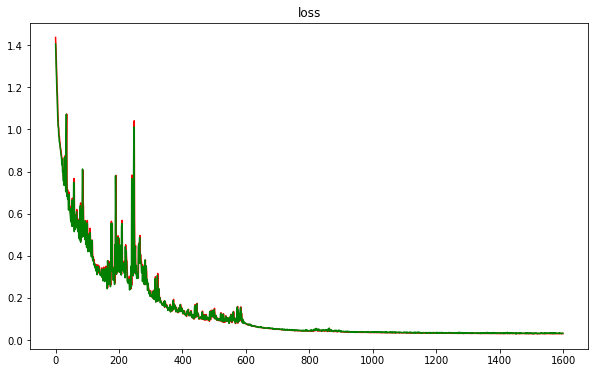

In [45]:
plt.rcParams['figure.figsize']=[10, 6]
plt.title('loss')
plt.plot(loss_arr['train'], color='r')
plt.plot(loss_arr['valid'], color='g')
plt.show()

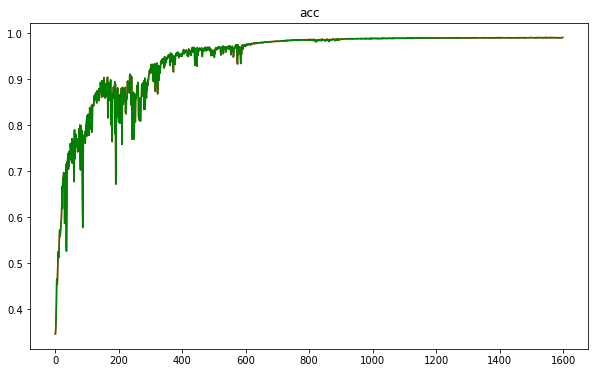

In [46]:
plt.rcParams['figure.figsize']=[10, 6]
plt.title('acc')
plt.plot(acc_arr['train'], color='r')
plt.plot(acc_arr['valid'], color='g')
plt.show()

In [47]:
#평가 부분 작성

In [59]:
def roc_pipe(y_true, y_score):
    from sklearn.metrics import roc_curve, roc_auc_score
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='RT + LR')
    #plt.text(0.55, 0.6, roc_auc_score(y_true, y_score), size=10)

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    plt.close()

In [63]:
for batch_id, (x_batch, y_batch) in enumerate(test_dataloader):
    with torch.no_grad():
        x_batch = x_batch.float().to(device)
        y_batch = y_batch.long().to(device)
        out = model(x_batch)

        test_acc = calc_accuracy(out, y_batch)
        

print('test acc: ', test_acc)



test acc:  0.99065
